In [22]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00


An AutoClass automatically infers the model architecture and downloads pretrained configuration and weights. Generally, we recommend using an AutoClass to produce checkpoint-agnostic code. But users who want more control over specific model parameters can create a custom 🤗 Transformers model from just a few base classes. This could be particularly useful for anyone who is interested in studying, training or experimenting with a 🤗 Transformers model. In this guide, dive deeper into creating a custom model without an AutoClass. Learn how to:

Load and customize a model configuration.
Create a model architecture.
Create a slow and fast tokenizer for text.
Create an image processor for vision tasks.
Create a feature extractor for audio tasks.
Create a processor for multimodal tasks.

Configuration

A configuration refers to a model’s specific attributes. Each model configuration has different attributes; for instance, all NLP models have the hidden_size, num_attention_heads, num_hidden_layers and vocab_size attributes in common. These attributes specify the number of attention heads or hidden layers to construct a model with.

Get a closer look at DistilBERT by accessing DistilBertConfig to inspect it’s attributes:



In [1]:
from transformers import DistilBertConfig

config = DistilBertConfig()
print(config)

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.38.1",
  "vocab_size": 30522
}



DistilBertConfig displays all the default attributes used to build a base DistilBertModel. All attributes are customizable, creating space for experimentation. For example, you can customize a default model to:

Try a different activation function with the activation parameter.
Use a higher dropout ratio for the attention probabilities with the attention_dropout parameter.

In [2]:
my_config = DistilBertConfig(activation="relu", attention_dropout=0.4)
print(my_config)

DistilBertConfig {
  "activation": "relu",
  "attention_dropout": 0.4,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.38.1",
  "vocab_size": 30522
}



Pretrained model attributes can be modified in the from_pretrained() function:

In [3]:
my_config = DistilBertConfig.from_pretrained("distilbert/distilbert-base-uncased", activation="relu", attention_dropout=0.4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Once you are satisfied with your model configuration, you can save it with save_pretrained(). Your configuration file is stored as a JSON file in the specified save directory:

In [4]:
my_config.save_pretrained(save_directory="./your_model_save_path")

To reuse the configuration file, load it with from_pretrained():

In [5]:
my_config = DistilBertConfig.from_pretrained("./your_model_save_path/config.json")

You can also save your configuration file as a dictionary or even just the difference between your custom configuration attributes and the default configuration attributes! See the configuration documentation for more details.
Model

The next step is to create a model. The model - also loosely referred to as the architecture - defines what each layer is doing and what operations are happening. Attributes like num_hidden_layers from the configuration are used to define the architecture. Every model shares the base class PreTrainedModel and a few common methods like resizing input embeddings and pruning self-attention heads. In addition, all models are also either a torch.nn.Module, tf.keras.Model or flax.linen.Module subclass. This means models are compatible with each of their respective framework’s usage.

Pytorch
Hide Pytorch content

Load your custom configuration attributes into the model:

In [6]:
from transformers import DistilBertModel

my_config = DistilBertConfig.from_pretrained("./your_model_save_path/config.json")
model = DistilBertModel(my_config)

This creates a model with random values instead of pretrained weights. You won’t be able to use this model for anything useful yet until you train it. Training is a costly and time-consuming process. It is generally better to use a pretrained model to obtain better results faster, while using only a fraction of the resources required for training.

Create a pretrained model with from_pretrained():

In [7]:
model = DistilBertModel.from_pretrained("distilbert/distilbert-base-uncased")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

When you load pretrained weights, the default model configuration is automatically loaded if the model is provided by 🤗 Transformers. However, you can still replace - some or all of - the default model configuration attributes with your own if you’d like:

In [8]:
model = DistilBertModel.from_pretrained("distilbert/distilbert-base-uncased", config=my_config)

 Model heads

At this point, you have a base DistilBERT model which outputs the hidden states. The hidden states are passed as inputs to a model head to produce the final output. 🤗 Transformers provides a different model head for each task as long as a model supports the task (i.e., you can’t use DistilBERT for a sequence-to-sequence task like translation).

Pytorch
Hide Pytorch content

For example, DistilBertForSequenceClassification is a base DistilBERT model with a sequence classification head. The sequence classification head is a linear layer on top of the pooled outputs.

In [9]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Easily reuse this checkpoint for another task by switching to a different model head. For a question answering task, you would use the DistilBertForQuestionAnswering model head. The question answering head is similar to the sequence classification head except it is a linear layer on top of the hidden states output.

In [10]:
from transformers import DistilBertForQuestionAnswering

model = DistilBertForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer

The last base class you need before using a model for textual data is a tokenizer to convert raw text to tensors. There are two types of tokenizers you can use with 🤗 Transformers:

PreTrainedTokenizer: a Python implementation of a tokenizer.
PreTrainedTokenizerFast: a tokenizer from our Rust-based 🤗 Tokenizer library. This tokenizer type is significantly faster - especially during batch tokenization - due to its Rust implementation. The fast tokenizer also offers additional methods like offset mapping which maps tokens to their original words or characters.

Both tokenizers support common methods such as encoding and decoding, adding new tokens, and managing special tokens.

Not every model supports a fast tokenizer. Take a look at this table to check if a model has fast tokenizer support.

If you trained your own tokenizer, you can create one from your vocabulary file:

In [12]:
from transformers import DistilBertTokenizer

my_tokenizer = DistilBertTokenizer(vocab_file="/content/drive/MyDrive/tweets_ase.txt", do_lower_case=False, padding_side="left")

It is important to remember the vocabulary from a custom tokenizer will be different from the vocabulary generated by a pretrained model’s tokenizer. You need to use a pretrained model’s vocabulary if you are using a pretrained model, otherwise the inputs won’t make sense. Create a tokenizer with a pretrained model’s vocabulary with the DistilBertTokenizer class:

In [13]:
from transformers import DistilBertTokenizer

slow_tokenizer = DistilBertTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Create a fast tokenizer with the DistilBertTokenizerFast class:

In [14]:
from transformers import DistilBertTokenizerFast

fast_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert/distilbert-base-uncased")

By default, AutoTokenizer will try to load a fast tokenizer. You can disable this behavior by setting use_fast=False in from_pretrained.
Image processor

An image processor processes vision inputs. It inherits from the base ImageProcessingMixin class.

To use, create an image processor associated with the model you’re using. For example, create a default ViTImageProcessor if you are using ViT for image classification:

In [15]:
from transformers import ViTImageProcessor

vit_extractor = ViTImageProcessor()
print(vit_extractor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



If you aren’t looking for any customization, just use the from_pretrained method to load a model’s default image processor parameters.

Modify any of the ViTImageProcessor parameters to create your custom image processor:

In [16]:
from transformers import ViTImageProcessor

my_vit_extractor = ViTImageProcessor(resample="PIL.Image.BOX", do_normalize=False, image_mean=[0.3, 0.3, 0.3])
print(my_vit_extractor)

ViTImageProcessor {
  "do_normalize": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.3,
    0.3,
    0.3
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": "PIL.Image.BOX",
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



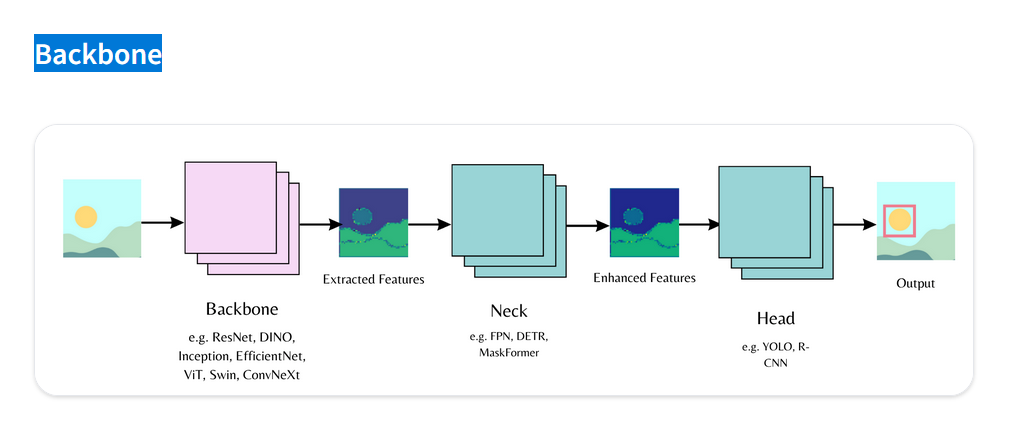

Computer vision models consist of a backbone, neck, and head. The backbone extracts features from an input image, the neck combines and enhances the extracted features, and the head is used for the main task (e.g., object detection). Start by initializing a backbone in the model config and specify whether you want to load pretrained weights or load randomly initialized weights. Then you can pass the model config to the model head.

For example, to load a ResNet backbone into a MaskFormer model with an instance segmentation head:

Set use_pretrained_backbone=True to load pretrained ResNet weights for the backbone.

In [1]:
from transformers import MaskFormerConfig, MaskFormerForInstanceSegmentation, ResNetConfig

backbone_config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config = MaskFormerConfig(backbone_config=backbone_config)
model = MaskFormerForInstanceSegmentation(config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


timm models are loaded with TimmBackbone and TimmBackboneConfig.

In [2]:
from transformers import TimmBackboneConfig, TimmBackbone

backbone_config = TimmBackboneConfig("resnet50")
model = TimmBackbone(config=backbone_config)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Feature extractor

A feature extractor processes audio inputs. It inherits from the base FeatureExtractionMixin class, and may also inherit from the SequenceFeatureExtractor class for processing audio inputs.

To use, create a feature extractor associated with the model you’re using. For example, create a default Wav2Vec2FeatureExtractor if you are using Wav2Vec2 for audio classification:

In [3]:
from transformers import Wav2Vec2FeatureExtractor

w2v2_extractor = Wav2Vec2FeatureExtractor()
print(w2v2_extractor)

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



If you aren’t looking for any customization, just use the from_pretrained method to load a model’s default feature extractor parameters.

Modify any of the Wav2Vec2FeatureExtractor parameters to create your custom feature extractor:

In [4]:
from transformers import Wav2Vec2FeatureExtractor

w2v2_extractor = Wav2Vec2FeatureExtractor(sampling_rate=8000, do_normalize=False)
print(w2v2_extractor)

Wav2Vec2FeatureExtractor {
  "do_normalize": false,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 8000
}



Processor

For models that support multimodal tasks, 🤗 Transformers offers a processor class that conveniently wraps processing classes such as a feature extractor and a tokenizer into a single object. For example, let’s use the Wav2Vec2Processor for an automatic speech recognition task (ASR). ASR transcribes audio to text, so you will need a feature extractor and a tokenizer.

Create a feature extractor to handle the audio inputs:

In [10]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(padding_value=1.0, do_normalize=True)

Create a tokenizer to handle the text inputs:

In [8]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer(vocab_file="/content/drive/MyDrive/tweets_ase.txt")

JSONDecodeError: Unexpected UTF-8 BOM (decode using utf-8-sig): line 1 column 1 (char 0)

In [9]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

NameError: name 'tokenizer' is not defined

With two basic classes - configuration and model - and an additional preprocessing class (tokenizer, image processor, feature extractor, or processor), you can create any of the models supported by 🤗 Transformers. Each of these base classes are configurable, allowing you to use the specific attributes you want. You can easily setup a model for training or modify an existing pretrained model to fine-tune.